basic VAE setup 

# Setup

In [1]:
import os
import warnings
import copy
import pylab as plt
from pathlib import Path 
import argparse
import multiprocessing
import h5py

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset
# from torch.utils.data.dataset import random_split
# from torch.optim.lr_scheduler import StepLR

import pyro
assert pyro.__version__ >= "0.3.0"
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, StepLR

from astropy.io import fits
from skimage.transform import resize

# from src.utils.setup_cosmos_data_loaders import setup_data_loaders, COSMOSDataset
from torchvision.transforms import Compose
from src.utils.setup_cosmos_data_loaders_optimized import COSMOSDataset, NoiseMeanSubtract, Normalize, Denoise, ToTensor
from src.utils.beta_elbo import Beta_ELBO

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
torch.manual_seed(0)

# Run options

In [48]:
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ
NUM_PROC = 'NUM_PROC' in os.environ

# Run options
USE_CUDA = False
SMALL_RUN = True

#smoke_test = True
# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 31
TEST_FREQUENCY = 5
if smoke_test: print("Smoke test active; this will only run for {} epochs".format(NUM_EPOCHS))

IMG_DIMS = (64, 64)
Z_DIM = 64
H_DIM = 4096
# BETA = 20
BATCH_SIZE = 64
CHUNK_SIZE = 512
TEST_FRAC = 0.10 # 90% train, 10% test
# INFILE = "../data/processed/COSMOS_rot_crop_resize_chunk.hdf5" #load from HDD
INFILE = "C:/Users/Paul/Research/COSMOS_FULL.hdf5" #load from SSD

BASE_LR = 1e-4
LR_STEP = 40
LR_GAMMA = 0.1

In [49]:
print("Nr of CPU threads available: {}".format(multiprocessing.cpu_count()))

NUM_THREADS = multiprocessing.cpu_count()
if NUM_THREADS < 4:
    print("Non-beast hardware detected, running on num_workers:0 (main process).")
    NUM_THREADS = 0
else:
    print("Using all {} threads.".format(NUM_THREADS))

if USE_CUDA:
    print("GPU run.")
    device = torch.device("cuda:0")
    N_GPUS = torch.cuda.device_count()  # @UndefinedVariable
    print("Nr of GPU's available: {}".format(N_GPUS))
else:
    print("CPU run.")
    
KWARGS = {'num_workers':NUM_THREADS, 'pin_memory':USE_CUDA}
# KWARGS = {}

Nr of CPU threads available: 4
Using all 4 threads.
CPU run.


# Load Galaxy Data

In [50]:
GD = COSMOSDataset(filename=INFILE,
                 transform=Compose(
                     [ 
                        NoiseMeanSubtract(),
                         Normalize("tanh"), #normalize to [-1,1]
                         ToTensor()
                     ]))

55969
Compose(
)
2
torch.Size([1, 64, 64])
torch.float32
{'I_e': tensor(0.0134), 'index': tensor(1.1454), 'noise_mean': tensor(-0.8797), 'noise_variance': tensor(0.0050), 'q': tensor(0.3201), 'r_e': tensor(41.3908), 'z': tensor(0.1950)}
torch.float32
1033
1.0 -1.0


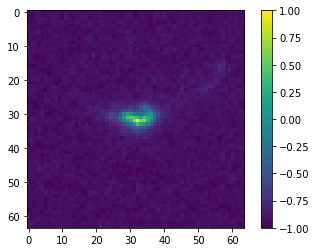

In [60]:
def quickcheck():
    print(len(GD))
    print(GD.transform)
    print(len(GD[0:256]))
    print(GD[0][0].shape)
    print(GD[0][0].dtype)
#     print(GD[0][1].dtype)
    print(GD[0][1])
    print(GD[0][1]["I_e"].dtype)
    x = np.random.randint(50373,55969)
    print(x-50373)
    plt.imshow(GD[x][0][0])
    print(np.max(np.array(GD[x][0][0], dtype=float)), np.min(np.array(GD[x][0][0], dtype=float)))
    plt.colorbar()
    plt.show()

quickcheck()

In [61]:
def get_train_test_len(full_set=GD, test_frac=None, sizes=None):
    assert test_frac != None or sizes!=None
    # Determine dataset sizes
    if test_frac is not None:
        n_test = int(test_frac * len(full_set))
        n_train = len(full_set) - n_test
    else:
        assert(sum(sizes)<=len(full_set))
        n_train, n_test = sizes
                       
    return n_train, n_test

train_n, test_n = get_train_test_len(test_frac=0.10) 
print(f"train n: {train_n}\ntest n: {test_n}")

train n: 50373
test n: 5596


In [62]:
if SMALL_RUN:
    train_n = CHUNK_SIZE * 10
    test_n = CHUNK_SIZE

# VAE setup

## Decoder/Encoder

In [63]:
class Encoder(nn.Module):
    def __init__(self, z_dim, h_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.layers = nn.Sequential(
            nn.Linear(4096, self.h_dim*8), #1024
            nn.ELU(),
            nn.Linear(self.h_dim*8, self.h_dim*4), #512
            nn.ELU(),
            nn.Linear(self.h_dim*4, self.h_dim), #128
            nn.ELU()
        )
        self.fc21 = nn.Linear(self.h_dim, self.z_dim)
        self.fc22 = nn.Linear(self.h_dim, self.z_dim)

    def forward(self, x):
        x = x.reshape(-1, IMG_DIMS[0]*IMG_DIMS[1])
        x = self.layers(x)
        z_loc = self.fc21(x)
        z_scale = torch.exp(self.fc22(x))
        return z_loc, z_scale
    
class Decoder(nn.Module):
    def __init__(self, z_dim, h_dim):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.layers = nn.Sequential(
            nn.Linear(z_dim, self.h_dim), #128
            nn.ELU(),
            nn.Linear(self.h_dim, self.h_dim*4), #512
            nn.ELU(),
            nn.Linear(self.h_dim*4, self.h_dim*8), #1024
            nn.ELU()
        )
        self.fc21 = nn.Linear(self.h_dim*8, 4096)
#         self.fc22 = nn.Linear(self.h_dim*8, 4096)

    def forward(self, z):
        z = self.layers(z)
        img_loc = self.fc21(z)
#         img_scale = 0.01*torch.exp(self.fc22(z))
        img_scale = 0.02 #noise = 1/50
        return img_loc, img_scale

## VAE

In [64]:
class VAE(nn.Module):
    def __init__(self, z_dim=Z_DIM, h_dim=H_DIM, use_cuda=USE_CUDA, encoder=Encoder, decoder=Decoder):
        super(VAE, self).__init__()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.encoder = encoder(z_dim, h_dim)
        self.decoder = decoder(z_dim, h_dim)
        if use_cuda:
            self.cuda()

    # define the model p(x|z)p(z) 
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            img_loc, img_scale = self.decoder.forward(z)
            # score against actual images
#             print(img_loc.shape)
#             print(x.reshape(-1, IMG_DIMS[0]*IMG_DIMS[1]).shape)
            pyro.sample("obs", dist.Normal(img_loc, img_scale).to_event(1), obs=x.reshape(-1, IMG_DIMS[0]*IMG_DIMS[1]))
#             pyro.sample("obs", dist.Bernoulli(img_loc).to_event(1), obs=x.reshape(-1, IMG_DIMS[0]*IMG_DIMS[1]))
            return img_loc

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1)) 

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        img_loc, img_scale = self.decoder(z)
        return img_loc.reshape(-1,64,64)

## train/evaluate

In [65]:
def train(svi, dataset, train_n, use_cuda=USE_CUDA, batch_size=BATCH_SIZE):
    epoch_loss = 0.
    for i in np.arange(0, train_n, step=batch_size):
        img, info = dataset[i:i+batch_size]
        if use_cuda:
            img = img.cuda()
        epoch_loss += svi.step(img)
        del(img)
        del(info)

    #final (smaller) batch
    img, info = dataset[i:train_n]
    if use_cuda:
        img = img.cuda()
    epoch_loss += svi.step(img)
    del(img)
    del(info)

    total_epoch_loss_train = epoch_loss / train_n
    return total_epoch_loss_train

In [66]:
def evaluate(svi, dataset, train_n, use_cuda=USE_CUDA, batch_size=BATCH_SIZE):
    test_loss = 0.
    for i in np.arange(train_n, len(dataset), step=batch_size):
        img, info = dataset[i:i+batch_size]
        if use_cuda:
            img = img.cuda()
        test_loss += svi.evaluate_loss(img)
        del(img)
        del(info)
        
    #final (smaller) batch
    img, info = dataset[i:len(dataset)] 
    if use_cuda:
        img = img.cuda()
    test_loss += svi.evaluate_loss(img)
    del(img)
    del(info)
    total_epoch_loss_test = test_loss / ((len(dataset)-test_n))
    return total_epoch_loss_test

In [67]:
def eval_visual(vae, dataset, train_n, comp_n=4984):
    img, info = dataset[train_n + comp_n]
    img = img.cuda()
    rec = vae.reconstruct_img(img)
    img = np.array(img.detach().cpu().reshape(64,64))
    rec = np.array(rec.detach().cpu().reshape(64,64))
   
    img_max = np.max(img)
    img_min = np.min(img)
    
    max_val = np.amax([np.amax(img), np.amax(rec)])
    min_val = np.amin([np.amin(img), np.amin(rec)])
    print(f"img: max = {np.amax(img):.4f}, min = {np.amin(img):.4f}")
    print(f"red: max = {np.amax(rec):.4f}, min = {np.amin(rec):.4f}")
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    im_org = axes[0].imshow(img, vmin=min_val, vmax=max_val)
    im_rec = axes[1].imshow(rec, vmin=min_val, vmax=max_val)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im_org, cax=cbar_ax)
    plt.show()

# Perform training VAE

In [68]:
def main_1():
    train_n, test_n = get_train_test_len(test_frac=TEST_FRAC)

    # setup the VAE
    vae = VAE(z_dim=Z_DIM, h_dim=H_DIM, use_cuda=USE_CUDA, encoder=Encoder, decoder=Decoder)

    # setup the optimizer
    optimizer = Adam({'lr': BASE_LR})
#     optimizer = torch.optim.Adam
#     optimizer = pyro.optim.StepLR({'optimizer': optimizer, 'optim_args': {'lr': BASE_LR}, 'step_size':LR_STEP, 'gamma': LR_GAMMA})

    # setup the inference algorithm
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

    train_elbo = []
    test_elbo = []

    print(f"training started!\nParameters:\nZ_DIM = {Z_DIM}\nH_DIM = {H_DIM}\nBASE_LR = {BASE_LR}")
    for epoch in range(NUM_EPOCHS):
#         if epoch!=0: print(pyro_scheduler.get_state()['encoder$$$layers.6.bias'].keys())
#         if epoch!=0: print(pyro_scheduler.get_state()['encoder$$$layers.6.bias'])
        total_epoch_loss_train = train(svi, GD, train_n, use_cuda=USE_CUDA, batch_size=BATCH_SIZE)
#         svi.optim.set_epoch(epoch)
        train_elbo.append(-total_epoch_loss_train)
        print("[epoch %03d] \taverage training loss: %.4f" % (epoch, total_epoch_loss_train))

        if epoch % TEST_FREQUENCY == 0:
            total_epoch_loss_test = evaluate(svi, GD, train_n, use_cuda=USE_CUDA, batch_size=BATCH_SIZE)
            test_elbo.append(-total_epoch_loss_test)
            if epoch == 0:
                print("[epoch {:03d}] \taverage test loss: {:.4f}".format(epoch, total_epoch_loss_test))
            else: 
                loss_change = test_elbo[-2] - test_elbo[-1]
                print("[epoch {:03d}] \taverage test loss: {:.4f} ({}{:.4f})".format(epoch, total_epoch_loss_test, ("+" if loss_change>0 else ""), loss_change))
            eval_visual(vae, GD, train_n)
    
    return vae, optimizer, svi, train_elbo, test_elbo

In [69]:
results1 = main_1() 

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at ..\aten\src\TH\THGeneral.cpp:201

## Check trained VAE

In [119]:
output_path = Path("./src/models/pretrained_models/")

In [113]:
# save vae
my_decoder = copy.deepcopy(results1[0].decoder)
my_encoder = copy.deepcopy(results1[0].encoder)
stringystring = "ph-NOUPLOAD-T-vae_basic_fc-decoder_z="+str(Z_DIM)+"_h="+str(H_DIM)+"_N_Epochs="+str(NUM_EPOCHS)+".pt"
torch.save(my_decoder.state_dict(), str(output_path / stringystring))
stringystring = "ph-NOUPLOAD-T-vae_basic_fc-encoder_z="+str(Z_DIM)+"_h="+str(H_DIM)+"_N_Epochs="+str(NUM_EPOCHS)+".pt"
torch.save(my_encoder.state_dict(), str(output_path / stringystring))

In [18]:
# # load VAE
# vae = VAE(z_dim=Z_DIM, c_dim=C_DIM, use_cuda=USE_CUDA, encoder=Encoder, decoder=Decoder)
# stringystring = "ph-03-BVAE-decoder_z="+str(Z_DIM)+"_beta="+str(BETA)+"_N_Epochs="+str(NUM_EPOCHS)+".pt"
# vae.decoder.load_state_dict(torch.load(str(output_path / stringystring)))
# stringystring = "ph-03-BVAE-encoder_z="+str(Z_DIM)+"_beta="+str(BETA)+"_N_Epochs="+str(NUM_EPOCHS)+".pt"
# vae.encoder.load_state_dict(torch.load(str(output_path / stringystring)))

In [114]:
# Freeze encoder and decoder parameters
for p in my_decoder.parameters():
    p.requires_grad = False
for p in my_encoder.parameters():
    p.requires_grad = False

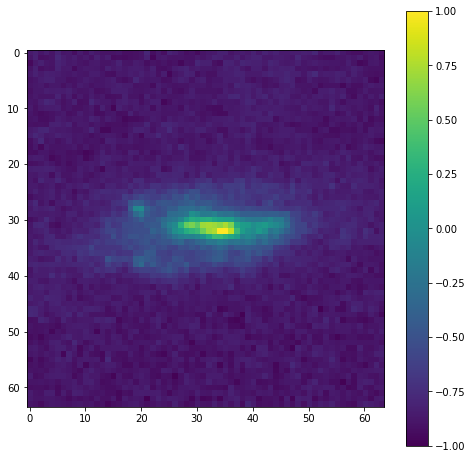

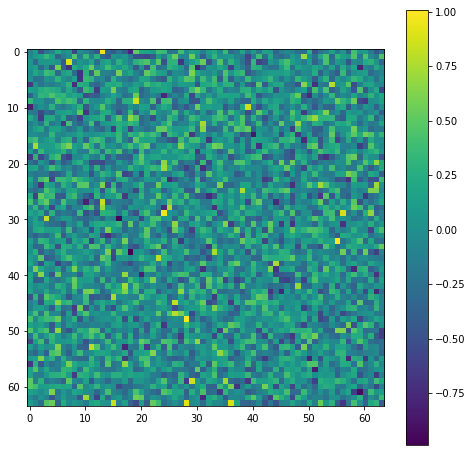

In [115]:
img, info = GD[0]
rec = results1[0].reconstruct_img(img.cuda()).reshape(64,64).detach().cpu()

fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(img.squeeze())
plt.colorbar()
plt.show()
fig2, ax2 = plt.subplots(figsize=(8,8))
plt.imshow(rec)
plt.colorbar()
plt.show()

In [130]:
def big_plotter(used_vae, x=4, y=8, title="BASIC FC MODEL RECONSTRUCTION SHEET", offset=train_n, use_cuda=USE_CUDA, tofile=True):
    """ 
    Compare first x*y images with their reconstructed counterparts. 
    Green = originals, red = reconstructions.
    """
    fig, axes = plt.subplots(x*2, y, sharex=True, sharey=True, figsize=(x*4, y*2))
    print(axes.shape)
    fig.subplots_adjust(hspace=0, wspace=0)

    for i in range(x):
        for j in range(y):
            img, info = GD[i*y + j+offset]
            if use_cuda:
                img = img.cuda()
            rec = used_vae.reconstruct_img(img)
            
            img = np.array(img.detach().cpu().reshape(64,64))
            rec = np.array(rec.detach().cpu().reshape(64,64))
            max_val = np.amax([np.amax(img), np.amax(rec)])
            min_val = np.amin([np.amin(img), np.amin(rec)])
            
            axes[i*2, j].imshow(img, vmin=min_val, vmax=max_val)
            axes[i*2+1, j].imshow(rec, vmin=min_val, vmax=max_val)
            axes[i*2, j].set_yticks([0,32])
            axes[i*2, j].set_xticks([0,32])
            axes[i*2+1, j].set_yticks([0,32])
            axes[i*2+1, j].set_xticks([0,32])
            green = axes[i*2, j].spines #originals
            red = axes[i*2+1, j].spines #reconstructions
            for s in red:
                green[s].set_color('lime')
                green[s].set_linewidth(3.)
                red[s].set_color('red')
                red[s].set_linewidth(3.)
    plt.suptitle(title, size=20)
    save_path = Path("./src/ph-thesis/" + title + ".png")
    fig.savefig(save_path)
    plt.show()

(8, 8)


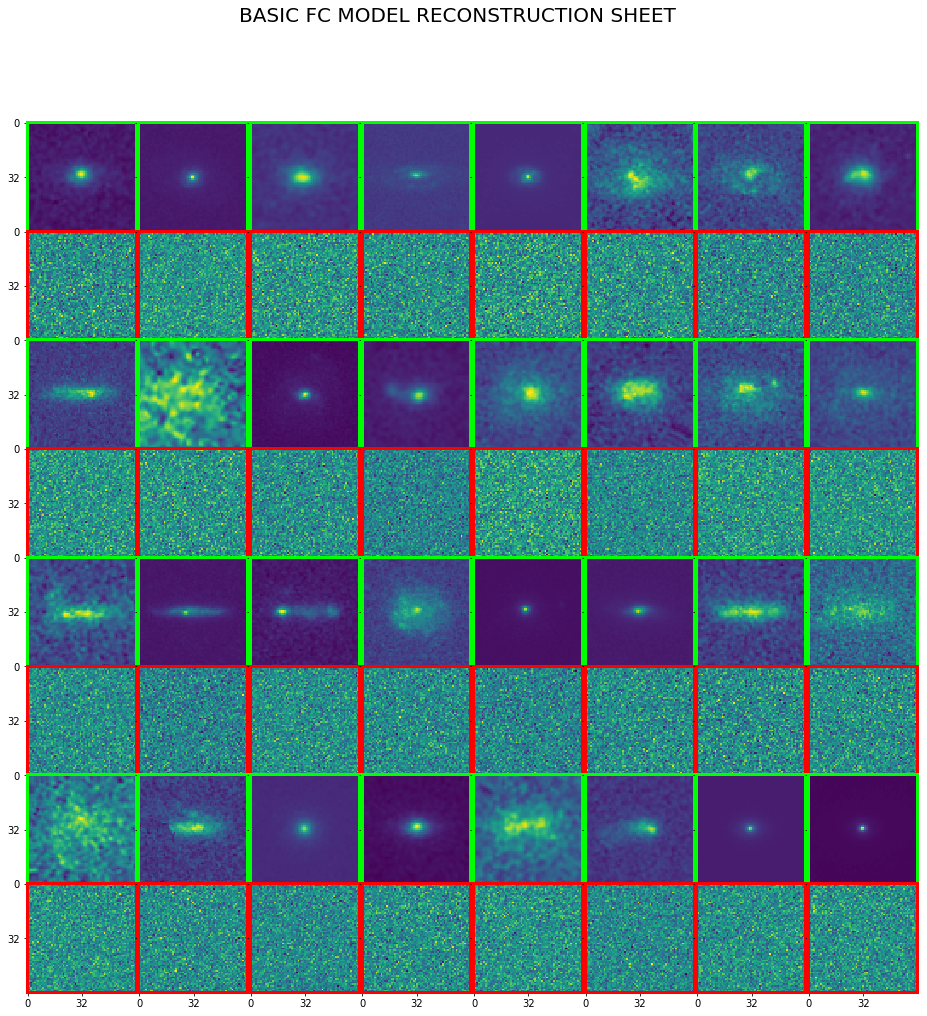

In [131]:
big_plotter(used_vae=results1[0])
# N=31, B=20

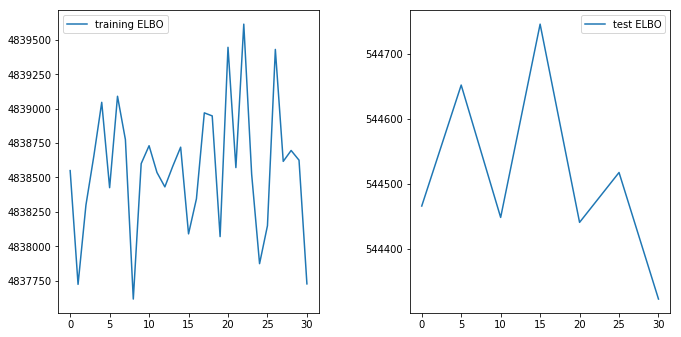

In [159]:
#basic elbo plot
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(range(0,31,1), np.abs(results1[3]), label='training ELBO')
axes[1].plot(range(0,31,5), np.abs(results1[4]), label='test ELBO')
axes[0].legend()
axes[1].legend()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
fig.savefig('./src/ph-thesis/elbo_plots_basic_fc.png')
plt.show()



# reconstruction comparisons

(8, 8)


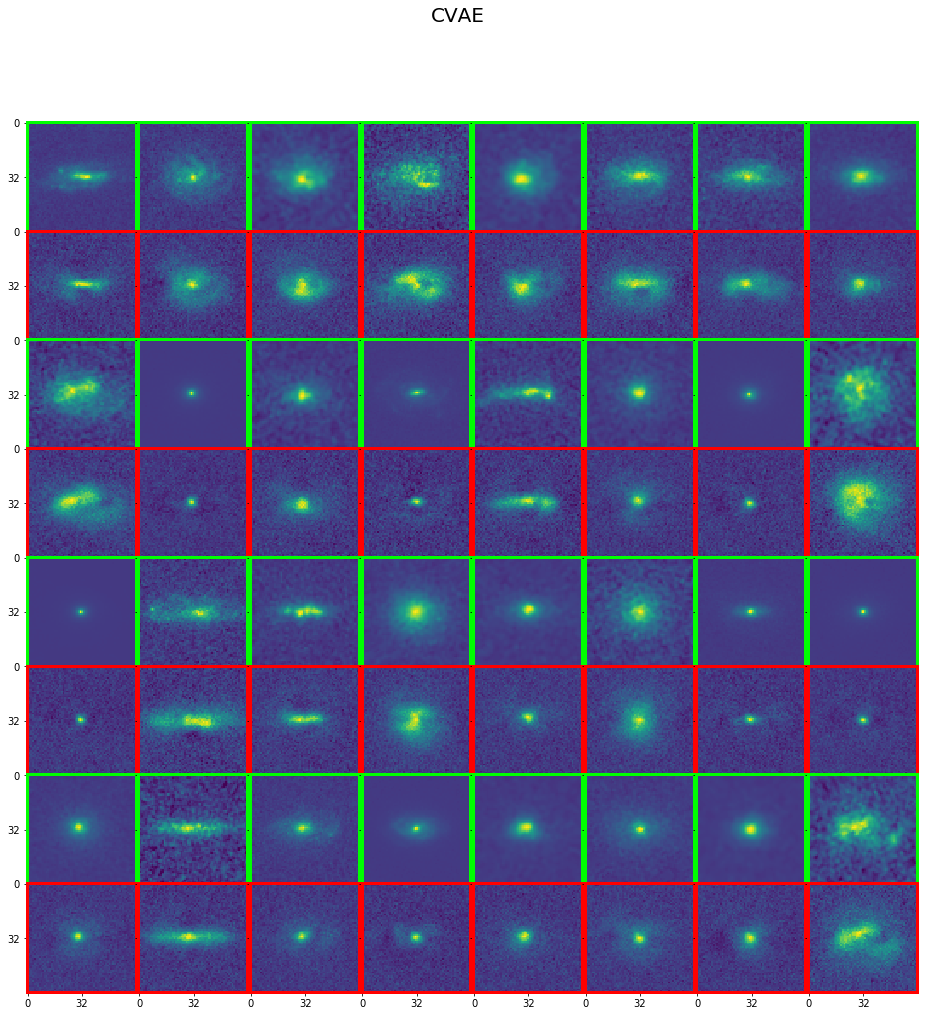

In [19]:
# big_plotter(used_vae=results1[0], cond=False, norm=True)
big_plotter(used_vae=vae, cond=False, norm=True)
# N=31, B=20,

(8, 8)


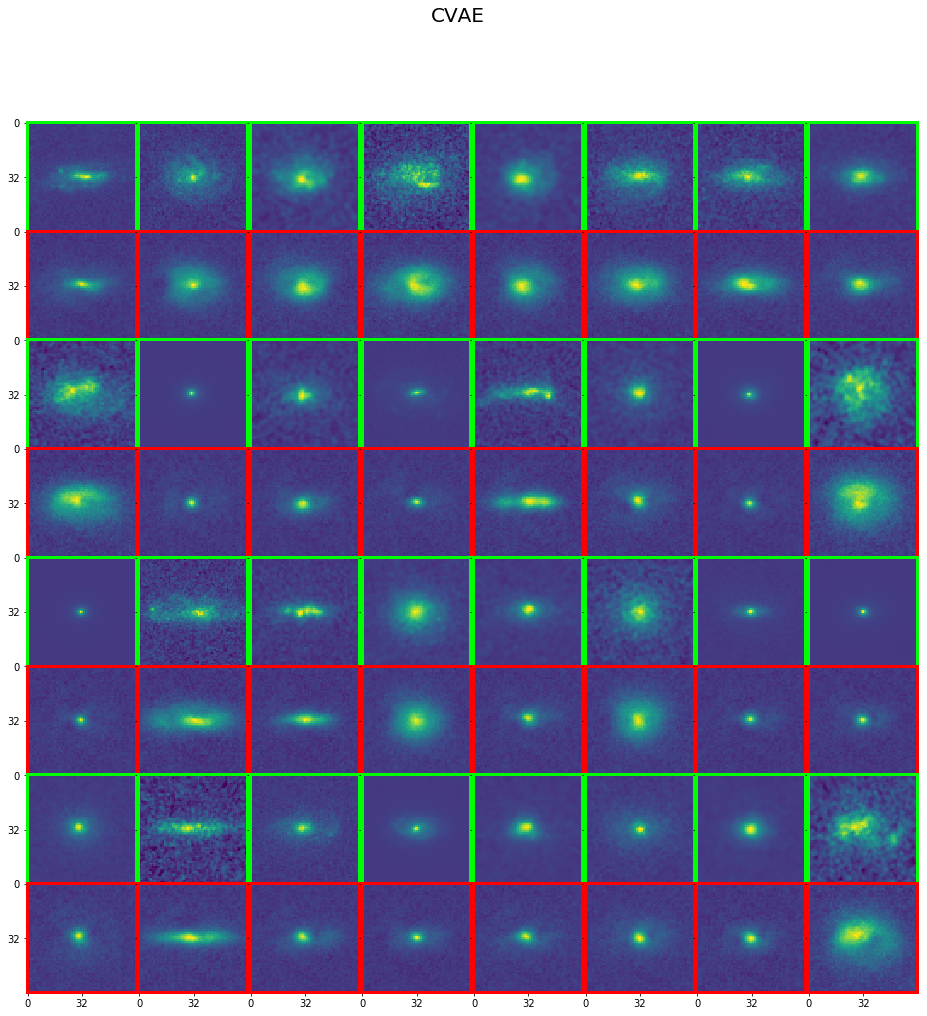

In [17]:
big_plotter(used_vae=results1[0], cond=False, norm=True)
# N=31, B=50

(8, 8)


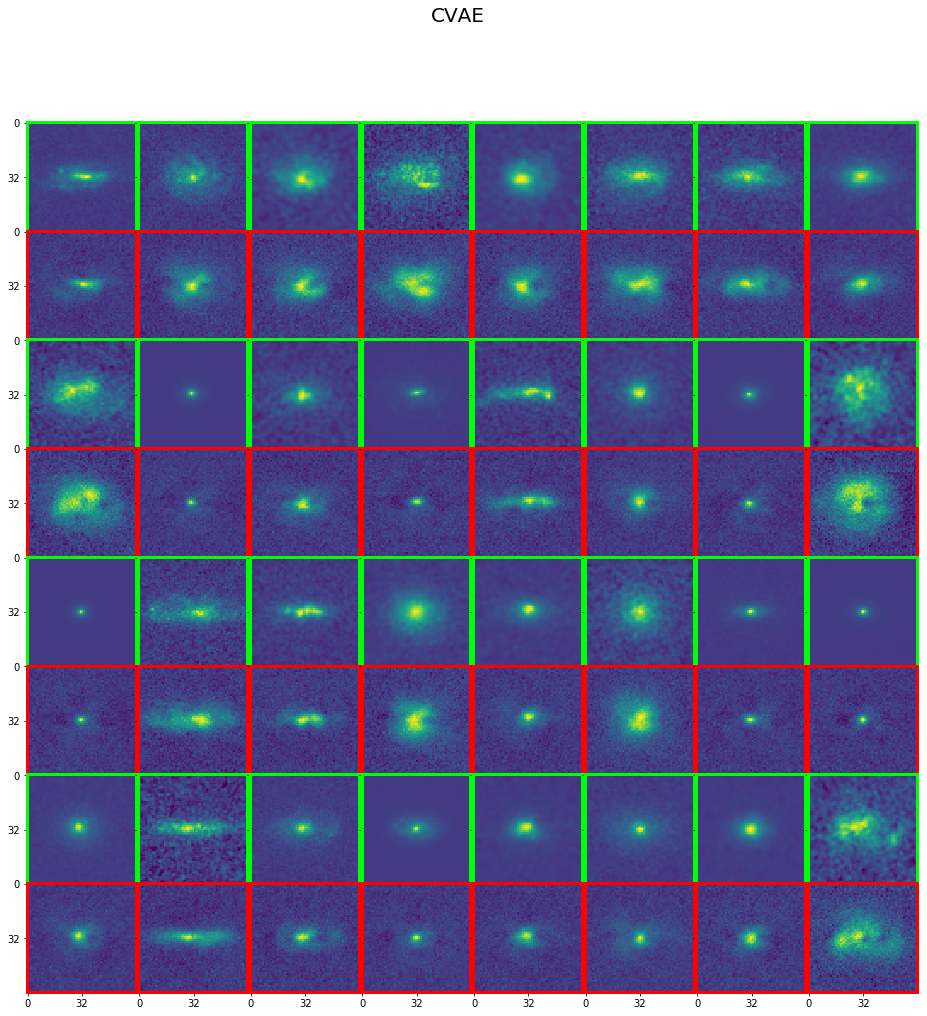

In [17]:
big_plotter(used_vae=results1[0], cond=False, norm=True)
# N=31, B=10

(8, 8)


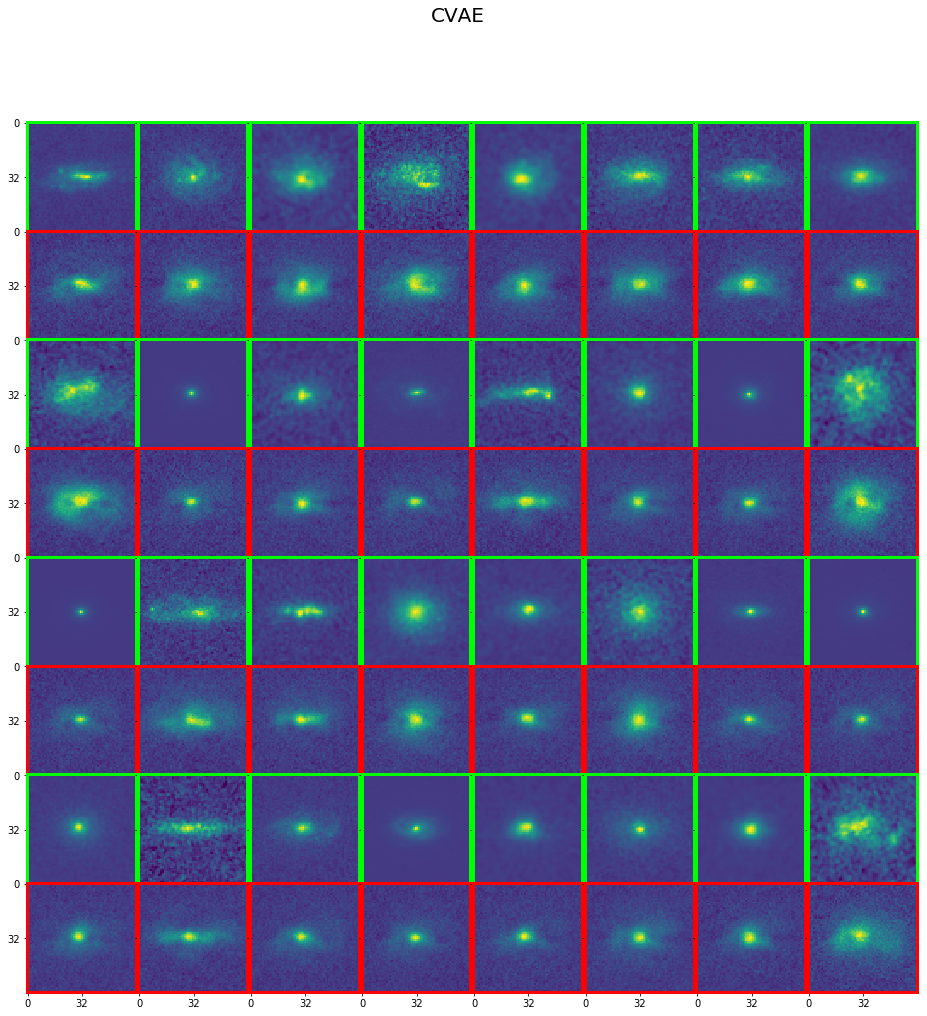

In [17]:
big_plotter(used_vae=results1[0], cond=False, norm=True)
# N=31, B=30

# some attempts at generation

In [18]:
from sklearn.mixture import BayesianGaussianMixture as BGMM

In [19]:
# generate full set of latent vars

vae_64d = results1[0]

# Freeze encoder and decoder parameters
for p in vae_64d.decoder.parameters():
    p.requires_grad = False
for p in vae_64d.encoder.parameters():
    p.requires_grad = False
    
latent_array = np.zeros(len(GD), 0)
  